In [2]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To build classification models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For tuning the model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Reading files
path = '../../datasets/'

travel_train = pd.read_csv(path + 'Traveldata_train.csv')
survey_train = pd.read_csv(path + 'Surveydata_train.csv')
travel_test = pd.read_csv(path + 'Traveldata_test.csv')
survey_test = pd.read_csv(path + 'Surveydata_test.csv')

datasets = [travel_train, survey_train, travel_test, survey_test]

for df in datasets:
    print(df.shape)

(94379, 9)
(94379, 17)
(35602, 9)
(35602, 16)


In [31]:
# UDFs to clean input missing values and creating dummy variables
def fill_nas_with_mode(df, col):
    mode = df[col].mode().iloc[0]
    df[col].fillna(mode, inplace=True)

def fill_nas_with_median(df, col):
    median = df[col].median()
    df[col].fillna(median, inplace=True)
    
def merge_dfs(travel_df, survey_df):
    result_df = travel_df.merge(survey_df, how='outer', on='ID', indicator=True)
    return result_df
    
def cleaning_df(df):
    # segregating categorical columns from numerical columns
    cat_cols = df.describe(include='object').columns.tolist()
    num_cols = df.describe().columns.tolist()
    
    # filling missing values
    for col in cat_cols:
        fill_nas_with_mode(df, col)

    for col in num_cols:
        fill_nas_with_median(df, col)
        
    # getting dummies
    dumm_df = df.drop(columns=['ID','_merge'])
    dumm_df = pd.get_dummies(dumm_df, drop_first=True)
    
    # editing names of dummy columns
    dumm_df.columns = dumm_df.columns.str.strip()
    dumm_df.columns = dumm_df.columns.str.replace(' ', '_')
    
    return dumm_df

In [32]:
train_df = merge_dfs(travel_train,survey_train)
test_df = merge_dfs(travel_test,survey_test)

In [33]:
num_cols = test_df.describe().columns.tolist() # extracting num cols with test_df since there's no Overall_Experience
cat_cols = test_df.describe(include='object').columns.tolist()

# reducing categorical variables

In [12]:
def cat_reducer(df):
    '''Reduced the categories of some categorical columns.'''
    
    reducer = {'Excellent':'positive',
                'Good':'positive',
                'Acceptable':'positive',
                'Needs Improvement':'negative',
                'Poor':'negative',
                'Extremely Poor':'negative'}

    platform_reducer = {'Very Convenient':'positive',
                        'Convenient':'positive',
                        'Manageable':'neutral',
                        'Needs Improvement':'negative',
                        'Inconvenient':'negative'}

    for col in cat_cols:
        
        # skipping cat cols that don't need reducing.
        if col in ['Gender','Customer_Type','Type_Travel','Travel_Class','Seat_Class']:
            pass
        
        elif col == 'Platform_Location':      
            df[col] = df[col].map(platform_reducer)
            
        else: 
            df[col] = df[col].map(reducer)

In [13]:
simple_train_df = train_df.copy()

cat_reducer(simple_train_df)
simple_train_df.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,_merge
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0,0,...,negative,positive,negative,negative,positive,negative,positive,negative,negative,both
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0,0,...,negative,positive,positive,positive,negative,negative,negative,positive,positive,both
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0,1,...,positive,positive,positive,positive,positive,positive,positive,positive,positive,both
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0,0,...,negative,positive,positive,positive,positive,positive,positive,positive,positive,both
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0,1,...,positive,positive,positive,positive,positive,positive,positive,positive,positive,both


In [14]:
simple_test_df = test_df.copy()

cat_reducer(simple_test_df)
simple_test_df.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,_merge
0,99900001,Female,NaN,36.0,Business Travel,Business,532,0.0,0.0,positive,...,positive,positive,positive,positive,positive,positive,positive,positive,negative,both
1,99900002,Female,Disloyal Customer,21.0,Business Travel,Business,1425,9.0,28.0,negative,...,negative,positive,positive,positive,positive,positive,positive,positive,positive,both
2,99900003,Male,Loyal Customer,60.0,Business Travel,Business,2832,0.0,0.0,positive,...,positive,positive,negative,negative,negative,negative,positive,negative,positive,both
3,99900004,Female,Loyal Customer,29.0,Personal Travel,Eco,1352,0.0,0.0,positive,...,positive,positive,negative,positive,negative,positive,positive,positive,negative,both
4,99900005,Male,Disloyal Customer,18.0,Business Travel,Business,1610,17.0,0.0,positive,...,positive,positive,positive,NaN,positive,positive,positive,positive,positive,both


# handling missing values

In [27]:
simple_train_df.isna().sum().sort_values(ascending=False) / simple_train_df.shape[0]

Type_Travel                0.097755
Customer_Type              0.094841
Arrival_Time_Convenient    0.094619
Catering                   0.092616
Onboard_Service            0.080537
Arrival_Delay_in_Mins      0.003783
Baggage_Handling           0.001505
Online_Support             0.000964
Legroom                    0.000954
CheckIn_Service            0.000816
Gender                     0.000816
Ease_of_Online_Booking     0.000773
Seat_Comfort               0.000646
Departure_Delay_in_Mins    0.000604
Age                        0.000350
Platform_Location          0.000339
Onboard_Wifi_Service       0.000318
Onboard_Entertainment      0.000191
Online_Boarding            0.000064
Cleanliness                0.000064
ID                         0.000000
Seat_Class                 0.000000
Overall_Experience         0.000000
Travel_Distance            0.000000
Travel_Class               0.000000
_merge                     0.000000
dtype: float64

In [34]:
for col in cat_cols:
    
    # create a new category if 5% or more of the values in that column are missing
    if simple_train_df[col].isna().sum() / simple_train_df.shape[0] > 0.05:
        simple_train_df[col] = simple_train_df[col].fillna('NAN')
    else:
        fill_nas_with_mode(simple_train_df, col)

for col in num_cols:
    fill_nas_with_median(simple_train_df, col)

In [37]:
simple_train_df.isna().sum().sort_values(ascending=False) / simple_train_df.shape[0]

ID                         0.0
Gender                     0.0
Online_Boarding            0.0
Cleanliness                0.0
CheckIn_Service            0.0
Baggage_Handling           0.0
Legroom                    0.0
Onboard_Service            0.0
Ease_of_Online_Booking     0.0
Online_Support             0.0
Onboard_Entertainment      0.0
Onboard_Wifi_Service       0.0
Platform_Location          0.0
Catering                   0.0
Arrival_Time_Convenient    0.0
Seat_Class                 0.0
Seat_Comfort               0.0
Overall_Experience         0.0
Arrival_Delay_in_Mins      0.0
Departure_Delay_in_Mins    0.0
Travel_Distance            0.0
Travel_Class               0.0
Type_Travel                0.0
Age                        0.0
Customer_Type              0.0
_merge                     0.0
dtype: float64

In [38]:
simple_test_df.isna().sum().sort_values(ascending=False) / simple_test_df.shape[0]

Type_Travel                0.096848
Customer_Type              0.095023
Catering                   0.094292
Arrival_Time_Convenient    0.093394
Onboard_Service            0.080670
Arrival_Delay_in_Mins      0.003455
Baggage_Handling           0.001124
Gender                     0.000843
Departure_Delay_in_Mins    0.000815
Online_Support             0.000730
Legroom                    0.000702
Seat_Comfort               0.000618
CheckIn_Service            0.000618
Ease_of_Online_Booking     0.000506
Platform_Location          0.000337
Onboard_Wifi_Service       0.000337
Age                        0.000309
Onboard_Entertainment      0.000225
Cleanliness                0.000056
Online_Boarding            0.000056
ID                         0.000000
Seat_Class                 0.000000
Travel_Distance            0.000000
Travel_Class               0.000000
_merge                     0.000000
dtype: float64

In [39]:
for col in cat_cols:
    
    # create a new category if 5% or more of the values in that column are missing
    if simple_test_df[col].isna().sum() / simple_test_df.shape[0] > 0.05:
        simple_test_df[col] = simple_test_df[col].fillna('NAN')
    else:
        fill_nas_with_mode(simple_test_df, col)

for col in num_cols:
    fill_nas_with_median(simple_test_df, col)

In [40]:
simple_test_df.isna().sum().sort_values(ascending=False) / simple_test_df.shape[0]

ID                         0.0
Platform_Location          0.0
Online_Boarding            0.0
Cleanliness                0.0
CheckIn_Service            0.0
Baggage_Handling           0.0
Legroom                    0.0
Onboard_Service            0.0
Ease_of_Online_Booking     0.0
Online_Support             0.0
Onboard_Entertainment      0.0
Onboard_Wifi_Service       0.0
Catering                   0.0
Gender                     0.0
Arrival_Time_Convenient    0.0
Seat_Class                 0.0
Seat_Comfort               0.0
Arrival_Delay_in_Mins      0.0
Departure_Delay_in_Mins    0.0
Travel_Distance            0.0
Travel_Class               0.0
Type_Travel                0.0
Age                        0.0
Customer_Type              0.0
_merge                     0.0
dtype: float64

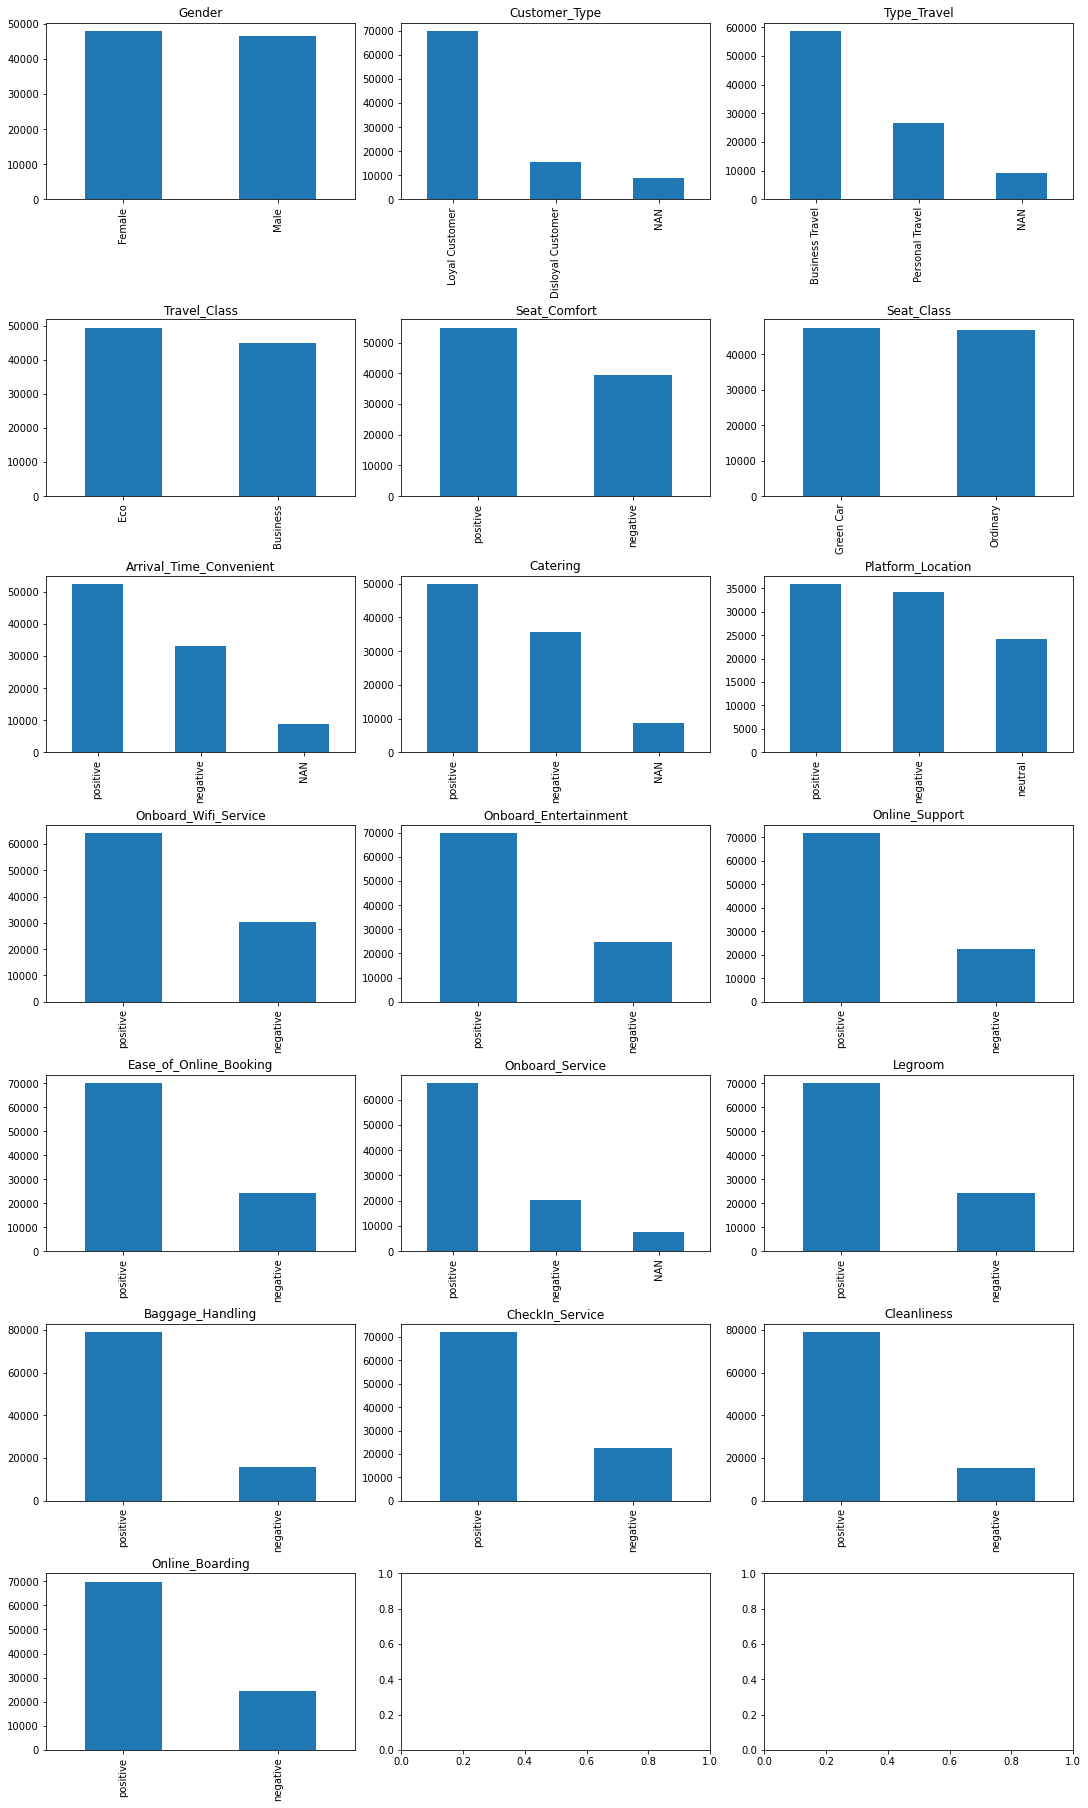

In [43]:
# assuming you have 21 columns:
fig,axes = plt.subplots(nrows=7, ncols=3, figsize=(15,25), constrained_layout=True)

# use `select_dtypes` to filter Object-type
for col, ax in zip(simple_train_df.select_dtypes(include='O'), axes.ravel()):
    simple_train_df[col].fillna('NA').value_counts().plot.bar(ax=ax)
    ax.set_title(col)
    
plt.show()

# random forest

## dummies

In [47]:
# getting dummies
dumm_train_df = simple_train_df.drop(columns=['ID','_merge'])
dumm_train_df = pd.get_dummies(dumm_train_df, drop_first=True)

# editing names of dummy columns
dumm_train_df.columns = dumm_train_df.columns.str.strip()
dumm_train_df.columns = dumm_train_df.columns.str.replace(' ', '_')

## model

In [48]:
X = dumm_train_df.drop(columns='Overall_Experience')
y = dumm_train_df['Overall_Experience']

In [49]:
y.value_counts(normalize=True)

1    0.546658
0    0.453342
Name: Overall_Experience, dtype: float64

In [50]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [51]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, random_state=1)

rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.453, 1: 0.547}, random_state=1)

## model evaluation


In [52]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Attrite', 'Attrite'], yticklabels=['Not Attrite', 'Attrite'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29950
           1       1.00      1.00      1.00     36115

    accuracy                           1.00     66065
   macro avg       1.00      1.00      1.00     66065
weighted avg       1.00      1.00      1.00     66065



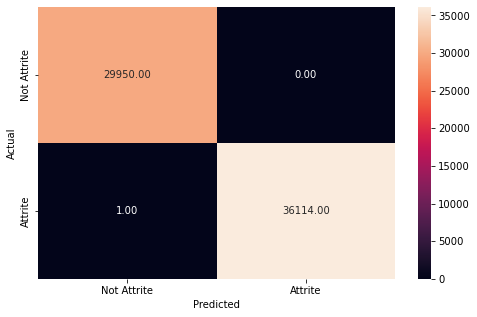

In [53]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(X_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12836
           1       0.89      0.88      0.88     15478

    accuracy                           0.87     28314
   macro avg       0.87      0.87      0.87     28314
weighted avg       0.87      0.87      0.87     28314



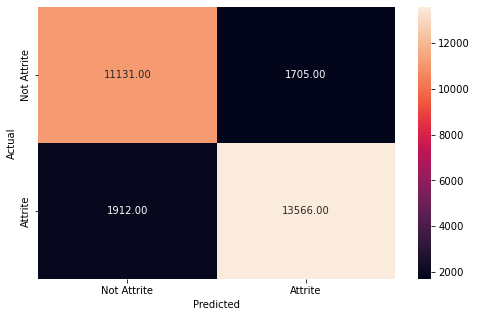

In [54]:
# Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(X_test)

metrics_score(y_test, y_pred_test_rf)

# Submission


In [56]:
# getting dummies
dumm_test_df = simple_test_df.drop(columns=['ID','_merge'])
dumm_test_df = pd.get_dummies(dumm_test_df, drop_first=True)

# editing names of dummy columns
dumm_test_df.columns = dumm_test_df.columns.str.strip()
dumm_test_df.columns = dumm_test_df.columns.str.replace(' ', '_')

In [59]:
X = dumm_test_df#.drop(columns='Overall_Experience')

In [60]:
preds = rf_estimator.predict(X)
submmission_df = pd.DataFrame(data = preds, 
                  index = test_df.ID.values, 
                  columns = ['Overall_Experience'])

submmission_df.rename_axis('ID', inplace=True)

In [61]:
submmission_df

,Overall_Experience
ID,
99900001,1
99900002,1
99900003,1
99900004,0
99900005,1
...,...
99935598,0
99935599,1
99935600,0


In [62]:
submmission_df.to_csv('submission5.csv')